In [1]:
#Install all the Reqiuired Libraries and Packages 
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
#get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

/Users/srinivasreddy/opt/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loading the required RAVDESS DataSet with length of 1439 Audio Files 
os.listdir(path='ravdess-dataset')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = 'ravdess-dataset'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

1440

In [3]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [4]:
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
    
def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1
            
def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [5]:
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [28]:
from tqdm import tqdm
import glob,pickle
for file in tqdm(glob.glob(r'/Users/srinivasreddy/Desktop/SER(TBP)/ravdess-dataset//**//*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= r'/Users/srinivasreddy/Desktop/SER(TBP)/clean-speech/'+str(file_name), rate=rate,data=signal[mask])

100%|███████████████████████████████████████| 1440/1440 [01:49<00:00, 13.12it/s]


In [39]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [40]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [49]:
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob(r'/Users/srinivasreddy/Desktop/SER(TBP)/clean-speech//*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=0)

In [50]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

(576, 180) (192, 180) (576, 2) (192, 2)
(576,) (192,)
03-01-02-02-02-01-05.wav
03-01-07-02-01-01-24.wav
03-01-03-02-02-02-14.wav
03-01-07-02-02-01-02.wav
03-01-02-01-02-02-04.wav
03-01-02-01-01-01-20.wav
03-01-06-01-02-01-09.wav
03-01-03-01-02-02-13.wav
03-01-06-02-01-01-11.wav
03-01-06-02-01-01-18.wav
03-01-06-01-01-02-23.wav
03-01-03-02-02-01-04.wav
03-01-02-02-01-02-22.wav
03-01-07-02-01-01-03.wav
03-01-02-02-02-01-02.wav
03-01-02-02-01-02-08.wav
03-01-07-02-02-01-06.wav
03-01-03-01-01-02-05.wav
03-01-02-01-01-02-23.wav
03-01-03-02-01-01-10.wav
03-01-07-01-01-02-04.wav
03-01-06-02-01-02-23.wav
03-01-03-02-01-02-22.wav
03-01-03-01-01-01-19.wav
03-01-07-01-01-01-17.wav
03-01-07-01-01-01-22.wav
03-01-02-01-02-02-21.wav
03-01-03-02-01-02-02.wav
03-01-07-01-01-01-14.wav
03-01-07-02-02-02-03.wav
03-01-06-01-01-01-12.wav
03-01-07-01-02-02-18.wav
03-01-07-01-02-01-14.wav
03-01-02-01-02-02-24.wav
03-01-02-01-01-02-21.wav
03-01-07-01-01-02-05.wav
03-01-07-01-02-01-01.wav
03-01-03-02-02-01-06.

In [51]:
print((x_train[0], x_test[0]))
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

(array([-4.42078552e+02,  8.12858124e+01, -2.53258400e+01,  2.21840630e+01,
       -1.96423244e+01, -2.49685345e+01, -3.02401047e+01, -2.24661579e+01,
       -1.65599213e+01, -9.46213245e+00, -1.99320869e+01, -1.09317112e+00,
       -2.93557358e+01,  6.98670292e+00, -2.19919529e+01, -2.95465636e+00,
       -1.11208372e+01, -5.35401106e+00, -1.44980822e+01, -4.49247694e+00,
       -8.06078815e+00, -9.13438797e+00, -3.94786620e+00,  6.97475076e-01,
       -7.89817619e+00,  4.91159010e+00, -2.39800096e+00,  6.57958984e+00,
        1.20758104e+01,  1.67727776e+01,  1.78446236e+01,  2.05926132e+01,
        1.04858236e+01,  1.22111483e+01,  8.17840672e+00,  1.57179356e+01,
        6.75951290e+00,  4.88085699e+00,  6.56202614e-01,  6.69358587e+00,
        3.98420572e-01,  3.97884399e-01,  4.04036909e-01,  4.93638724e-01,
        4.61070716e-01,  4.23144937e-01,  5.45499325e-01,  5.89998364e-01,
        6.85666203e-01,  5.78803599e-01,  4.92924243e-01,  3.87741745e-01,
        1.09974651e-04, 

In [52]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [53]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [54]:
#SAVING THE MODEL
import pickle
# Save the Modle to file in the current working directory
#For any new testing data other than the data in dataset

Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

In [55]:
# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model = pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [56]:
#predicting :
y_pred=Emotion_Voice_Detection_Model.predict(x_test)
y_pred

array(['fearful', 'disgust', 'happy', 'fearful', 'calm', 'calm', 'calm',
       'happy', 'fearful', 'fearful', 'fearful', 'happy', 'calm',
       'disgust', 'calm', 'calm', 'disgust', 'happy', 'calm', 'fearful',
       'disgust', 'happy', 'happy', 'happy', 'disgust', 'disgust', 'calm',
       'happy', 'fearful', 'disgust', 'fearful', 'disgust', 'disgust',
       'calm', 'calm', 'disgust', 'fearful', 'happy', 'disgust',
       'disgust', 'fearful', 'disgust', 'fearful', 'happy', 'fearful',
       'calm', 'happy', 'happy', 'calm', 'happy', 'fearful', 'calm',
       'happy', 'happy', 'disgust', 'fearful', 'fearful', 'disgust',
       'happy', 'happy', 'calm', 'fearful', 'disgust', 'happy', 'happy',
       'happy', 'happy', 'fearful', 'fearful', 'happy', 'fearful',
       'happy', 'happy', 'fearful', 'fearful', 'disgust', 'calm', 'happy',
       'calm', 'disgust', 'calm', 'calm', 'fearful', 'calm', 'fearful',
       'disgust', 'happy', 'fearful', 'calm', 'calm', 'happy', 'calm',
       'di

In [57]:
import numpy as np
import pandas as pd
y_pred1 = pd.DataFrame(y_pred, columns=['predictions'])
y_pred1['file_names'] = test_filename
print(y_pred1)
y_pred1.to_csv('predictionfinal.csv')

    predictions                file_names
0       fearful  03-01-02-02-02-01-05.wav
1       disgust  03-01-07-02-01-01-24.wav
2         happy  03-01-03-02-02-02-14.wav
3       fearful  03-01-07-02-02-01-02.wav
4          calm  03-01-02-01-02-02-04.wav
..          ...                       ...
187     disgust  03-01-07-02-01-02-14.wav
188     disgust  03-01-07-01-02-02-16.wav
189     disgust  03-01-02-01-01-02-10.wav
190        calm  03-01-02-02-02-01-09.wav
191     disgust  03-01-03-02-02-01-17.wav

[192 rows x 2 columns]


In [77]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 1
RATE = 16000 #sample rate
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "output10.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


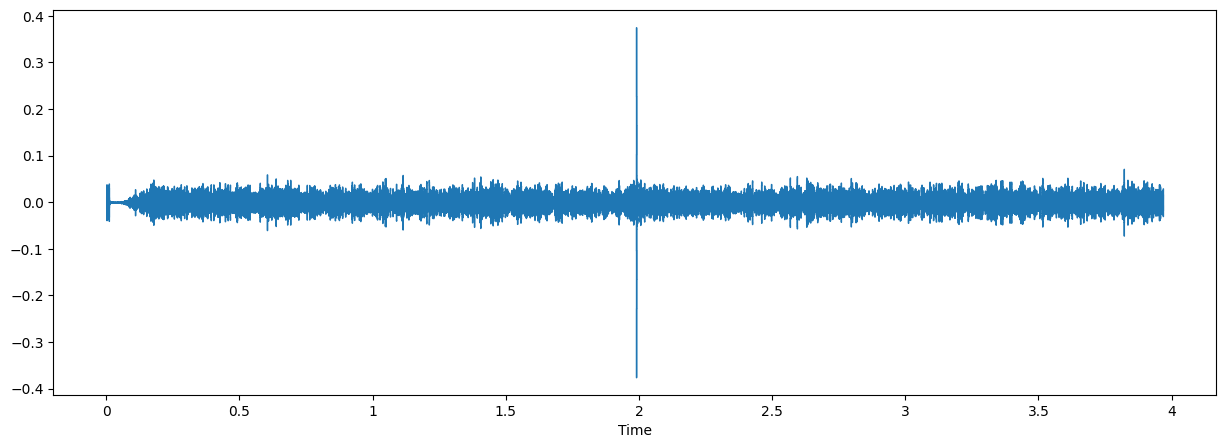

In [79]:
data, sampling_rate = librosa.load('output10.wav')
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)